In [170]:
import pyproj
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd

import time
from scipy.sparse import csr_matrix
from scipy.spatial.distance import squareform, pdist,euclidean
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.cluster import DBSCAN, KMeans,MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import time
import matplotlib.pyplot as plt

import pickle as pk
ox.config(use_cache=True, log_console=True)

In [4]:
place = 'Toronto, Ontario, Canada'
trees = gpd.read_file('./data/trees_reduced.shp')
# G = ox.graph_from_place(place, network_type='drive')
# pk.dump(G, open('./toronto.osmnx','wb'))
G = pk.load( open('./toronto.osmnx','rb'))

In [5]:
Gp = ox.project_graph(G, to_crs={'init': 'epsg:32617'})
treesprj = trees.to_crs(epsg=32617)
trees['x'] = trees.geometry.x
trees['y'] = trees.geometry.y
trees['xp'] = treesprj.geometry.x
trees['yp'] = treesprj.geometry.y

In [6]:
G_dm = nx.DiGraph(Gp)


In [164]:
%%time
# attach nearest network node to each firm
trees['nn'] = ox.get_nearest_nodes(Gp, X=trees['xp'], Y=trees['yp'], method='kdtree')
print(len(trees['nn'].unique()))

940
Wall time: 148 ms


In [165]:
nodes_unique = pd.Series(trees['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

940


In [193]:
trees['gx']= trees.nn.map(lambda x: G.node[x]['x'])
trees['gy']= trees.nn.map(lambda x: G.node[x]['y'])
trees['gxp']= trees.nn.map(lambda x: Gp.node[x]['x'])
trees['gyp']= trees.nn.map(lambda x: Gp.node[x]['y'])
trees['xp'] = treesprj.geometry.x
trees['yp'] = treesprj.geometry.y
# euclidean(trees[['gxp','gyp']],trees[['xp','yp']])

In [10]:
# create a euclidean distance vector between the nodes to quickly find nearby nodes within some distance threshold
x = nodes_unique.map(lambda x: Gp.node[x]['x'])
y = nodes_unique.map(lambda x: Gp.node[x]['y'])
df = pd.DataFrame({'x':x, 'y':y}, index=nodes_unique)
dist_matrix = squareform(pdist(X=df, metric='euclidean'))
df_dist_matrix = pd.DataFrame(data=dist_matrix, columns=df.index.values, index=df.index.values)
node_euclidean_dists = df_dist_matrix.stack()

In [32]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, node_euclidean_dists=node_euclidean_dists):
    
    # only calculate distances between u and nodes within 0.005 degrees (ie, ~400 m) of it
    nearby_nodes = node_euclidean_dists[u][node_euclidean_dists[u] < 1000].index
    # calculate network distances
    net_dists = []
    for v in nearby_nodes:
        try:
            net_dists.append(nx.dijkstra_path_length(G, source=u, target=v, weight='length'))
        except:
            net_dists.append(999999)
    # for all nodes beyond "nearby" cut-off, make distance anything larger than epsilon
    return pd.Series(data=net_dists, index=nearby_nodes).reindex(nodes_unique).fillna(99999)

In [122]:
node_dm3 = nodes_unique.apply(network_distance_matrix, G=G)


In [123]:
node_dm1 = node_dm3
node_dm1[node_dm1 == 0] = 1
node_dm1[node_dm1 > 3500] = 0
node_dms = csr_matrix(node_dm1)


In [279]:
knn_graph = kneighbors_graph(trees[['xp', 'yp']],500,mode='distance', metric='euclidean',  include_self=True,n_jobs=-1)

model = AgglomerativeClustering(linkage='ward', affinity='euclidean',connectivity=knn_graph,n_clusters=8)
trees['spatial_cluster'] =  model.fit_predict(trees[['xp', 'yp']])
i = trees['spatial_cluster'].value_counts()
trees['spatial_cluster'].value_counts()

0    1064
2     514
1     305
3     117
5      75
6      63
7      51
4      33
Name: spatial_cluster, dtype: int64

In [326]:
spatial_index = treesprj.sindex
for i,point in treesprj.iterrows():
    possible_matches_index = list(spatial_index.intersection(point.geometry.buffer(500).bounds))
    possible_matches = treesprj.iloc[possible_matches_index]
    if possible_matches <100 and 
   
#     n = len(t)/33 
#     print(n)
#     C, M, f =constrained_kmeans(possible_matches[['xp', 'yp']], [33 for i in range(n)], maxiter=1, fixedprec=1e9)

    # precise_matches = possible_matches[possible_matches.intersects(polygon)]

possible_matches

# i = trees['spatial_cluster'].value_counts()
# treesprj.buffer(250)
# def min_distance(point, lines):
#     return treesprj.distance(point).min()

# t = treesprj.geometry.apply(min_distance, treesprj)

# for k,v in i.iteritems(): 
#     if v > 100:
#         t=trees[trees['spatial_cluster']== k]
#         knn_graph = kneighbors_graph(t[['xp', 'yp']],len(t)/2,mode='distance', metric='euclidean',  include_self=True,n_jobs=-1)
#         m = trees['spatial_cluster'].max()+1
#         model = AgglomerativeClustering(linkage='ward', affinity='euclidean',connectivity=knn_graph,n_clusters=2)
#         # model = DBSCAN(eps=400, min_samples=2, metric='euclidean', algorithm='ball_tree')
#         cluster_labels =  model.fit_predict(t[['xp', 'yp']])
#         m= trees['spatial_cluster'].max()+1
#         cluster_labels = [l+m for l in cluster_labels]
#         m = l+m
#         trees.loc[t.index,'spatial_cluster'] = cluster_labels
#         print(trees['spatial_cluster'].value_counts())

140
140
72
56
68
153
38
45
45
65
72
127
68
59
53
87
56
13
2
20
102
40
38
127
127
15
63
143
49
31
12
7
12
30
24
24
103
37
41
62
31
32
25
84
78
61
37
126
103
53
54
54
8
27
28
30
2
59
101
103
104
16
164
38
27
27
15
21
166
125
24
17
46
74
35
37
51
41
41
124
120
126
122
119
94
22
18
98
90
65
46
48
49
47
47
51
37
39
53
46
72
18
127
12
76
65
70
130
131
27
20
20
14
30
12
41
30
12
60
19
8
35
67
87
12
116
83
85
74
2
22
59
42
14
141
141
151
127
52
6
17
22
11
14
14
68
33
10
18
33
20
12
20
32
3
32
44
2
8
130
64
63
73
95
62
137
140
132
159
48
73
1
140
71
138
72
59
60
50
11
12
12
13
13
49
3
14
11
13
13
30
37
6
74
91
80
71
124
139
140
137
140
123
42
41
42
2
75
25
58
83
77
77
77
75
4
128
104
87
91
78
26
77
160
168
101
115
45
143
126
30
16
120
120
155
153
132
119
124
81
82
35
37
65
37
53
9
22
116
9
9
7
19
4
12
12
12
12
12
14
58
54
58
61
48
31
77
47
28
27
34
6
32
67
99
65
58
97
112
22
54
118
137
126
112
113
20
32
22
46
51
46
46
110
40
40
31
134
99
35
31
26
26
109
106
114
36
36
6
112
44
26
57
39
107
6
92


,Loc_name,Status,Score,Match_type,Match_addr,Side,User_fld,Addr_type,ARC_Single,Address,...,Watering_P,x,y,xp,yp,spatial_cl,spatial__1,nn,network_cl,geometry
1678,StreetNameAdd,M,100.00,A,"38 The Esplanade, former Toronto",None,0,PointAddress,38 THE ESPLANADE,38 THE ESPLANADE,...,70,-79.374692,43.646926,631078.737089,4.833942e+06,20,0.0,29688188,0,POINT (631078.7370885123 4833942.332891324)
293,StreetNameAdd,M,100.00,A,"38 The Esplanade, former Toronto",None,0,PointAddress,38 THE ESPLANADE,38 THE ESPLANADE,...,70,-79.374692,43.646926,631078.737089,4.833942e+06,20,0.0,29688188,0,POINT (631078.7370885123 4833942.332891324)
1677,StreetNameAdd,M,100.00,A,"38 The Esplanade, former Toronto",None,0,PointAddress,38 THE ESPLANADE,38 THE ESPLANADE,...,10,-79.374692,43.646926,631078.737089,4.833942e+06,20,0.0,29688188,0,POINT (631078.7370885123 4833942.332891324)
1679,StreetNameAdd,M,100.00,A,"54 The Esplanade, former Toronto",None,0,PointAddress,54 THE ESPLANADE,54 THE ESPLANADE,...,10,-79.374364,43.646980,631105.041741,4.833949e+06,20,0.0,249975741,0,POINT (631105.0417412637 4833948.826040346)
927,StreetNameAdd,M,90.67,A,"1 Church St, former Toronto",None,0,PointAddress,"1 CHURCH ST, TORONTO","1 CHURCH ST, TORONTO",...,10,-79.372870,43.647033,631225.472229,4.833957e+06,20,0.0,2147483647,0,POINT (631225.4722293434 4833957.04118708)
1272,StreetNameAdd,M,100.00,A,"95 The Esplanade, former Toronto",None,0,PointAddress,95 THE ESPLANADE,95 THE ESPLANADE,...,50,-79.372723,43.647410,631236.505185,4.833999e+06,20,0.0,249975741,0,POINT (631236.5051854576 4833999.144495744)
2115,StreetNameAdd,M,100.00,A,"95 The Esplanade, former Toronto",None,0,PointAddress,95 THE ESPLANADE,95 THE ESPLANADE,...,50,-79.372723,43.647410,631236.505185,4.833999e+06,20,0.0,249975741,0,POINT (631236.5051854576 4833999.144495744)
1887,StreetNameAdd,M,100.00,A,"74 The Esplanade, former Toronto",None,0,PointAddress,74 THE ESPLANADE,74 THE ESPLANADE,...,50,-79.373060,43.647523,631209.056438,4.834011e+06,20,0.0,249975741,0,POINT (631209.0564382501 4834011.2169993)
1886,StreetNameAdd,M,100.00,A,"74 The Esplanade, former Toronto",None,0,PointAddress,74 THE ESPLANADE,74 THE ESPLANADE,...,20,-79.373060,43.647523,631209.056438,4.834011e+06,20,0.0,249975741,0,POINT (631209.0564382501 4834011.2169993)
1273,StreetNameAdd,M,100.00,A,"105 The Esplanade, former Toronto",None,0,PointAddress,105 THE ESPLANADE,105 THE ESPLANADE,...,10,-79.372416,43.647564,631260.891138,4.834017e+06,20,0.0,249977879,0,POINT (631260.8911379061 4834016.786420673)


In [ ]:
# t=trees[trees['spatial_cluster']== 15]
# knn_graph = kneighbors_graph(t[['xp', 'yp']],50,mode='distance', metric='euclidean',  include_self=True,n_jobs=-1)
# m = trees['spatial_cluster'].max()+1
# model = AgglomerativeClustering(linkage='ward', affinity='euclidean',connectivity=knn_graph,n_clusters=2)
# # model = DBSCAN(eps=400, min_samples=2, metric='euclidean', algorithm='ball_tree')
# cluster_labels =  model.fit_predict(t[['xp', 'yp']])
# cluster_labels = [l+m for l in cluster_labels]
# m = l+m+1
# trees.loc[t.index,'spatial_cluster'] = cluster_labels
# trees['spatial_cluster'].value_counts()

In [ ]:
n = len(trees)/37
C, M, f =constrained_kmeans(trees[['xp', 'yp']], [37 for i in range(n)], maxiter=1, fixedprec=1e9)

Calculating cost...
Preparing data_to_C_edges...
Calculating min cost flow...


In [325]:
i = trees['spatial_cluster'].value_counts()
trees['network_cluster'] =0
for k,v in i.iteritems(): 
    if v > 33:    
        t=trees[trees['spatial_cluster']== k]
        n = len(t)/33 
        print(n)
        C, M, f =constrained_kmeans(t[['xp', 'yp']], [33 for i in range(n)], maxiter=100, fixedprec=1e9)
        m= trees['network_cluster'].max()+1
        M = [l+m for l in M]
        m = l+m
        print(M)
        trees.loc[t.index,'network_cluster'] = M
    else:
        m= trees['network_cluster'].max()+1
        
        trees.loc[t.index,'network_cluster'] = m
        

10
Calculating cost...
Preparing data_to_C_edges...
Calculating min cost flow...


KeyboardInterrupt: 

In [306]:
knn_graph = kneighbors_graph(trees[['xp', 'yp']],500,mode='distance', metric='euclidean',  include_self=True,n_jobs=-1)

model = AgglomerativeClustering(linkage='ward', affinity='euclidean',connectivity=knn_graph,n_clusters=8)
trees['spatial_cluster'] =  model.fit_predict(trees[['xp', 'yp']])
t=trees[trees['spatial_cluster']== 0]

# trees['network_cluster'] = 0
# m = trees['network_cluster'].max()+1
# for i in trees['spatial_cluster'].unique():
#     t=trees[trees['spatial_cluster']== i]
#     try:
#         eps = node_dm1.loc[t.nn,t.nn].mean().to_xarray().mean()[0]/3
#     except:
#         eps = eps
#     # use metric=precomputed to fit model to the sparse network-based distance matrix
#     db = DBSCAN(eps=eps, min_samples=6, metric='precomputed')#AgglomerativeClustering( n_clusters=8, affinity='precomputed',linkage='complete')
#     node_dms = csr_matrix(node_dm1.loc[t.nn,t.nn])
    
#     cluster_labels = db.fit_predict(node_dms)
#     cluster_labels = [l+m for l in cluster_labels]
#     m = l+m+1
#     print(m,len(cluster_labels))
#     cluster_labels.sort()
#     trees.loc[t.index,'network_cluster'] = cluster_labels

In [116]:

%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=600, min_samples=2, metric='precomputed')
cluster_labels = db.fit_predict(node_dms)

Wall time: 11 ms


In [185]:
# map each firm's nearest-node to the node cluster labels
node_clusters = {node:label for node, label in zip(nodes_unique.index, cluster_labels)}
trees['network_cluster'] = trees['nn'].map(lambda x: node_clusters[x])
len(trees['network_cluster'].unique())

KeyError: 246692483L

In [145]:

# turn any clusters with fewer than minpts elements into noise
vc = trees['network_cluster'].value_counts()
noise_labels = vc.index[vc < 8]
row_idx = trees['network_cluster'].isin(noise_labels)
trees.loc[row_idx, 'network_cluster'] = -1

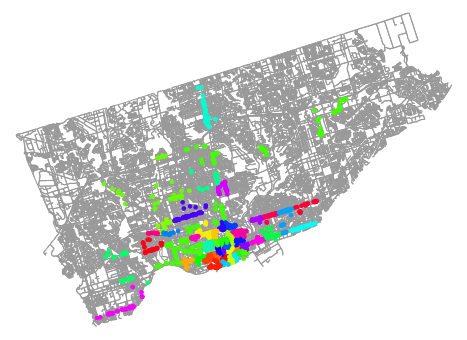

In [307]:
# get point colors by cluster
unique_labels = trees['network_cluster'].unique()
colors = ox.get_colors(n=len(unique_labels), cmap='hsv', return_hex=True)
color_map = {label:color for label, color in zip(unique_labels, colors)}
point_colors = [color_map[c] for c in trees['network_cluster']]
# plot firms by cluster
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.scatter(x=trees['x'], y=trees['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig



In [312]:
def constrained_kmeans(data, demand, maxiter=None, fixedprec=1e9):
	data = np.array(data)
	
	min_ = np.min(data, axis = 0)
	max_ = np.max(data, axis = 0)
	
	C = min_ + np.random.random((len(demand), data.shape[1])) * (max_ - min_)
	M = np.array([-1] * len(data), dtype=np.int)
	
	itercnt = 0
	while True:
		itercnt += 1
		
		# memberships
		g = nx.DiGraph()
		g.add_nodes_from(xrange(0, data.shape[0]), demand=-1) # points
		for i in xrange(0, len(C)):
			g.add_node(len(data) + i, demand=demand[i])
		
		print('Calculating cost...')
		cost = np.array([np.linalg.norm(np.tile(data.T, len(C)).T - np.tile(C, len(data)).reshape(len(C) * len(data), C.shape[1]), axis=1)])
		print('Preparing data_to_C_edges...') 
		data_to_C_edges = np.concatenate((np.tile([xrange(0, data.shape[0])], len(C)).T, np.tile(np.array([xrange(data.shape[0], data.shape[0] + C.shape[0])]).T, len(data)).reshape(len(C) * len(data), 1), cost.T * fixedprec), axis=1).astype(np.uint64)
		# Adding to graph
		g.add_weighted_edges_from(data_to_C_edges)
		

		a = len(data) + len(C)
		g.add_node(a, demand=len(data)-np.sum(demand))
		C_to_a_edges = np.concatenate((np.array([xrange(len(data), len(data) + len(C))]).T, np.tile([[a]], len(C)).T), axis=1)
		g.add_edges_from(C_to_a_edges)
		
		
		print('Calculating min cost flow...')
		f = nx.min_cost_flow(g)
		
		print('Assigning...')
		M_new = np.ones(len(data), dtype=np.int) * -1
		for i in xrange(len(data)):
			p = sorted(f[i].iteritems(), key=lambda x: x[1])[-1][0]
			M_new[i] = p - len(data)
			
		# stop condition
		if np.all(M_new == M):
			# Stop
			return (C, M, f)
			
		M = M_new
			
		# compute new centers
		for i in xrange(len(C)):
			C[i, :] = np.mean(data[M==i, :], axis=0)
			
		if maxiter is not None and itercnt >= maxiter:
			# Max iterations reached
			return (C, M, f)